接下来就可以采用多资产的联合预测了，业内比较常用的思路是预测相对强弱排名，即一个rank，这样做的主要原因还是前面提到的金融资产预测的问题：

以价格为目标的预测会发生伪拟合，以收益率为目标的预测会坍塌到0附近，而以符号做预测会丢失信息且容易出现模型懒惰现象，即模型只会预测一个分类，在学习到有价值信息之前陷入了一个很难逃离的局部最优。

其实造成这些问题的原因只有一个，那就是噪声的比例太大了。rank方法和我提出的hybrid loss本质上都是一样的，都是通过对预测目标进行预先的信息提取，提取出先验的有价值信息再让模型预测，人为的降低噪声的影响。

其实rank方法会更稳健一些，只不过rank方法只适用于多资产联合预测。

In [136]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import optuna
import math

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from modules import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

在 rank_Prediction_loss中讨论了损失函数，直接拿过来

In [137]:
class WeightedRankLoss(nn.Module):
    """
    加权排序损失函数，对于排序错配施加不同的权重损失
    """
    def __init__(self, alpha=0.5, p=1, q=2):
        """
        p 控制幅度权重的指数，衡量本次错配的距离，1为绝对差值 2为平方差之
        q 控制位置权重的指数，衡量本次错配发生的位置的重要性，1为绝对差值 2为平方差值
        alpha控制两个权重的比例，alpha越接近1，幅度权重越大
        """
        super().__init__()
        self.alpha = alpha
        self.p = p
        self.q = q
        
        self.bceloss = nn.BCEWithLogitsLoss(reduction='none') # 用这个版本的BCE可以直接输入logits，但现在需要设置reduction='none' 来拿到原始的loss来加权

    def forward(self, pred, real):
        # 通过双重索引强制将real转换为rank
        sorted_indices = torch.argsort(real, dim=1)
        rank = torch.argsort(sorted_indices, dim=1)

        # 列出所有的ij组合
        num_assets = pred.shape[1]
        indices = torch.combinations(torch.arange(num_assets), r=2)
        indices = indices.to(pred.device)
        i_indices = indices[:, 0]
        j_indices = indices[:, 1]
        
        # 提取成对的预测分数和真实排名
        pred_i = pred[:, i_indices]
        pred_j = pred[:, j_indices]
        rank_i = rank[:, i_indices].float()
        rank_j = rank[:, j_indices].float()

        # 计算预测得分差和真实目标
        # 我们期望 pred_i > pred_j 当 rank_i > rank_j 时
        pred_diff = pred_i - pred_j
        # target=1.0 表示 i 应该排在 j 前面
        real_diff = (rank_i > rank_j).float()

        # 权重p: 错配的幅度 (Magnitude Weight)
        w_mag = torch.pow(torch.abs(rank_i - rank_j), self.p)
        
        # 权重q: 错配的位置 (Location Weight)
        mean_rank = (num_assets - 1) / 2.0
        mid_point = (rank_i + rank_j) / 2.0
        w_loc = torch.pow(torch.abs(mid_point - mean_rank), self.q)
        
        # 为了避免不同尺度问题，在混合前先对每个样本的权重进行归一化
        w_mag_normalized = w_mag / (w_mag.max(dim=1, keepdim=True)[0] + 1e-9)
        w_loc_normalized = w_loc / (w_loc.max(dim=1, keepdim=True)[0] + 1e-9)
        
        # 组合权重
        raw_weights = self.alpha * w_mag_normalized + (1 - self.alpha) * w_loc_normalized
        
        # 对最终权重进行归一化并缩放，使其平均值为1，以保持损失的量级稳定
        num_combinations = i_indices.shape[0]
        final_weights = (raw_weights / (raw_weights.sum(dim=1, keepdim=True) + 1e-9)) * num_combinations

        # 计算原始loss应用自定义权重
        unreduced_loss = self.bceloss(pred_diff, real_diff)
        weighted_loss = unreduced_loss * final_weights

        return weighted_loss.mean()

In [138]:
class PanelTransformerBackbone(nn.Module):
    def __init__(self, dim_patch_feature, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout):
        super().__init__()
        dim_encoder_input = dim_projection +  dim_temporal_embedding + dim_assets_embedding
        self.projection = nn.Linear(dim_patch_feature, dim_projection)
        self.assets_embedding = AssetsEmbedding(num_base_assets = num_bass_assets, embedding_dim = dim_assets_embedding, target_ratio = 0.2, freeze = True)
        self.temporal_embedding = TemporalEmbedding(dim_embedding = dim_temporal_embedding)
        self.panel_encoder = MultiLayerPanelEncoder(num_layer = num_layer, d_model = dim_encoder_input, num_head = num_head, num_ffn_hidden = dim_encoder_input * 2, dropout = dropout)

    def forward(self, x, weights):
        x = self.projection(x)
        x = self.temporal_embedding(x)
        x = self.assets_embedding(x, weights)
        x = self.panel_encoder(x)
        return x

model = PanelTransformerBackbone(dim_patch_feature = 120, dim_projection = 128, dim_temporal_embedding = 6, dim_assets_embedding = 10, num_bass_assets = 53, num_head = 8, num_layer = 3 , dropout = 0.5)
model.assets_embedding.load_state_dict(torch.load('params/assets_embedding.params'))

<All keys matched successfully>

In [139]:
class RankPanelTransformer(nn.Module):
    """Panel Time Series Transformer"""
    def __init__(self, dim_raw_feature, patch_size, stride, mask_expand_size, seq_len, dim_projection, dim_temporal_embedding, dim_assets_embedding, num_bass_assets, num_head, num_layer, dropout):
        super().__init__()
        # 模型参数
        self.device = 'cuda:0'
        self.input_size = dim_raw_feature
        self.patch_size = patch_size
        self.stride = stride
        self.mask_expand_size = mask_expand_size
        self.num_patch = int(np.floor((seq_len - patch_size) / stride) + 1)

        self.dim_projection = dim_projection

        dim_encoder_input = dim_projection +  dim_temporal_embedding + dim_assets_embedding

        # 前置层
        self.patch = TimeSeriesPatcher(patch_size, stride)

        # 编码层
        self.encoder = PanelTransformerBackbone(dim_patch_feature = dim_raw_feature * patch_size,
                                                  dim_projection = dim_projection,
                                                  dim_temporal_embedding = dim_temporal_embedding,
                                                  dim_assets_embedding = dim_assets_embedding,
                                                  num_bass_assets = num_bass_assets,
                                                  num_head = num_head,
                                                  num_layer = num_layer,
                                                  dropout = dropout)

        # 线性输出
        self.decoder = nn.Sequential(
            nn.Flatten(start_dim = -2),
            # nn.Linear(self.num_patch * dim_encoder_input, self.num_patch *dim_encoder_input),
            nn.Dropout(dropout),
            nn.Linear(self.num_patch * dim_encoder_input, 1),
            nn.Flatten(start_dim = -2),
        )

        # # 注意力式输出
        # self.decoder = nn.Sequential(
        #     nn.Flatten(start_dim = -2),
        #     # nn.Dropout(dropout),
        #     nn.Linear(dim_encoder_input*self.num_patch, dim_encoder_input),
        #     nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model = dim_encoder_input, nhead = 4, dim_feedforward=dim_encoder_input, dropout = dropout, batch_first=True, norm_first=True),num_layers = 3),
        #     # nn.Dropout(dropout),
        #     nn.Linear(dim_encoder_input, 1),
        #     nn.Flatten(start_dim = -2),
        # )
    
    def forward(self, x, weights):
        x_patched = self.patch(x)
        enc_out = self.encoder(x_patched, weights)
        output = self.decoder(enc_out)
        return output
    
    # # 重写 train 方法，来固定模型只训练输出层
    # def train(self, mode = True):
    #     super().train(mode)
    #     if mode:
    #         self.encoder.eval()


这里我对比了是否要控制预训练层参数不学习，和是否应该改用多层mlp输出，发现还是让预训练层也学习+单层mlp的效果更好

我分析原因可能是这样：

该模型的架构是，由encoder 完成纵向和横向的信息传递，最后 decoder完成最后一次纵向信息收集，然后输出

而我们的rank排名任务相比于simple prediction 任务更加强调截面关系，即在资产之间的横向对比，

因此，需要让encoder 的transformer 进一步学习这个任务。而decoder只起到传递作用，因此单层mlp的效果反而更好

In [140]:
dim_raw_feature = 10
patch_size = 8
stride = 4
mask_expand_size = 1
seq_len = 120
dim_projection = 80
dim_temporal_embedding = 38
dim_assets_embedding = 10
num_bass_assets = 53
num_head = 8
num_layer = 3
dropout = 0.8

batch_size = 64
learning_rate = 1e-3
weight_decay = 1e-1
gamma = 1

epochs = 10
test_size = 128

top = 5

In [141]:
# 加载数据
loaders = []
for i in [20110901, 20160901, 20210901]: 

    feature = torch.load(f'data/feature_{i}')
    label = torch.load(f'data/label_{i}')
    weights = torch.load(f'data/weights_{i}')

    train_set = TensorDataset(feature[:-test_size-seq_len], weights[:-test_size-seq_len], label[:-test_size-seq_len])
    train_loader = DataLoader(train_set, batch_size, True)
    loaders.append(train_loader)


feature = torch.load('data/feature_20210901')
label = torch.load('data/label_20210901')
weights = torch.load('data/weights_20210901')
test_set = TensorDataset(feature[-test_size:], weights[-test_size:], label[-test_size:])
test_loader = DataLoader(test_set, batch_size, False)

# test_loader 只需要最新的就行了，因为是一样的，重复test没意义

100%|██████████| 10/10 [00:25<00:00,  2.54s/it]


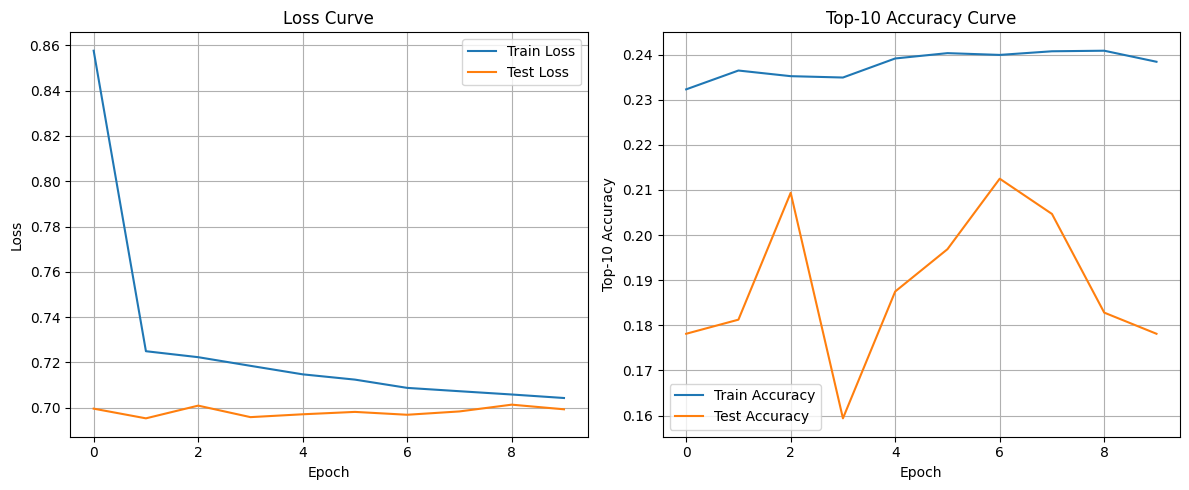

0.6988232493400574


In [142]:
loss_fn = WeightedRankLoss(alpha=0.5, p=1, q=1)

model = RankPanelTransformer(dim_raw_feature,patch_size,stride,mask_expand_size,seq_len,dim_projection,dim_temporal_embedding,dim_assets_embedding,num_bass_assets,num_head,num_layer,dropout).to('cuda:0')
model.encoder.load_state_dict(torch.load('params/panel_tf_backbone.params'))
model.encoder.assets_embedding.load_state_dict(torch.load('params/assets_embedding.params'))

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay = weight_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)


def accuracy(pred, real, top):
    """
    计算前10名资产的识别准确率
    """
    # 获取预测和真实的top资产的索引
    _, pred_top10_indices = torch.topk(pred, top, dim=1)
    _, real_top10_indices = torch.topk(real, top, dim=1)

    batch_accs = []
    # 对批次中的每个样本进行计算
    for i in range(pred.shape[0]):
        pred_set = set(pred_top10_indices[i].tolist())
        real_set = set(real_top10_indices[i].tolist())
        
        # 计算交集中的元素数量
        intersection_size = len(pred_set.intersection(real_set))
        
        # 计算该样本的准确率
        acc = intersection_size / top
        batch_accs.append(acc)
        
    # 返回批次的平均准确率
    return np.mean(batch_accs)


def epoch():
    train_losses, train_accs = [], []
    model.train()
    for loader in loaders:
        for batch_x, batch_weights, batch_y in loader:
            optimizer.zero_grad()
            pred = model(batch_x.to('cuda:0'), batch_weights.to('cuda:0'))
            batch_y = batch_y[...,0]# y 需要处理，只选第一列
            loss = loss_fn(pred, batch_y.to('cuda:0'))
            acc = accuracy(pred, batch_y.to('cuda:0'), top)
            train_losses.append(loss.item())
            train_accs.append(acc)
            loss.backward()
            optimizer.step()

    test_losses, test_accs = [], []
    model.eval()
    with torch.no_grad():
        for batch_x, batch_weights, batch_y in test_loader:
            pred = model(batch_x.to('cuda:0'), batch_weights.to('cuda:0'))
            batch_y = batch_y[...,0]# y 需要处理，只选第一列
            loss = loss_fn(pred, batch_y.to('cuda:0'))
            acc = accuracy(pred, batch_y.to('cuda:0'), top)
            test_losses.append(loss.item())
            test_accs.append(acc)

    return np.mean(train_losses), np.mean(test_losses), np.mean(train_accs), np.mean(test_accs)


def train(epochs = 30):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    for i in tqdm.tqdm(range(epochs)):
        train_loss, test_loss, train_acc, test_acc = epoch()
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        scheduler.step()

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), test_losses, label='Test Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accs, label='Train Accuracy')
    plt.plot(range(epochs), test_accs, label='Test Accuracy')
    plt.title('Top-10 Accuracy Curve') # 更新图表标题
    plt.xlabel('Epoch')
    plt.ylabel('Top-10 Accuracy') # 更新Y轴标签
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return np.mean(test_losses[-5:])

final_loss = train(epochs)
print(final_loss)

In [143]:
print(f'baseline accuracy: {top*top/50/10:.2%}')

baseline accuracy: 5.00%


first date of test set: 20230901
last date of test set: 20250829

In [144]:
assets_list = [
    # 股指期货
    'IH.CFX', 'IF.CFX', 'IC.CFX',
    # 国债期货
    'TS.CFX', 'TF.CFX', 'T.CFX', 'TL1.CFX',
    # 黑色金属产业链
    'I.DCE', 'JM.DCE', 'RB.SHF', 'HC.SHF', 'SS.SHF', 'SF.ZCE', 'SM.ZCE',
    # 有色金属
    'CU.SHF', 'AL.SHF', 'ZN.SHF', 'NI.SHF',
    # 贵金属
    'AU.SHF', 'AG.SHF',
    # 能源化工
    'FU.SHF', 'LU.INE', 'BU.SHF', 'PG.DCE', 'TA.ZCE', 'EG.DCE', 'PF.ZCE', 
    'L.DCE', 'PP.DCE', 'V.DCE', 'EB.DCE', 'MA.ZCE', 'UR.ZCE', 'RU.SHF',
    # 农产品
    'A.DCE', 'B.DCE', 'M.DCE', 'RM.ZCE', 'Y.DCE', 'OI.ZCE', 'P.DCE', 'PK.ZCE',
    'C.DCE', 'CS.DCE', 'CF.ZCE', 'SR.ZCE', 'CJ.ZCE', 'AP.ZCE', 'SP.SHF', 
    'JD.DCE', 'LH.DCE',
    # 建材
    'FG.ZCE', 'SA.ZCE'
]


In [145]:
import backtrader as bt

class TargetPositionStrategy(bt.Strategy):
    """
    简单单资产策略，对每个资产都一视同仁，不考虑相关性
    """
    params = (
        ('lookback', 5),
        ('capital_per_asset', 100000.0),  # 每个资产分配的固定金额
    )

    def __init__(self):
        self.log_dates = []
        self.log_values = []
        self.log_cash = []

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        
    def next(self):
        # 记录每日的总资产价值
        self.log_dates.append(self.data.datetime.date(0))
        self.log_values.append(self.broker.getvalue())
        self.log_cash.append(self.broker.getcash())


        # 遍历所有传入的数据（即所有资产）
        for d in self.datas:
            # 如果数据点不足以覆盖回望期，则跳过
            if len(d) < self.p.lookback:
                continue
            # 从 openinterest 获取预先计算好的信号
            signals = d.openinterest.get(size=self.p.lookback)
            signal_sum = sum(signals)
            target_pct = signal_sum / self.p.lookback
            # 计算目标仓位价值。
            target_value = self.p.capital_per_asset * target_pct
            # 调仓
            self.order_target_value(data=d, target=target_value)
    
    def stop(self):
        for d in self.datas:
            # 如果仍持有头寸 (无论是多头还是空头)，都通过将目标价值设为0来平仓
            if self.getposition(d).size != 0:
                self.log(f"Closing position for {d._name} at stop.")
                self.order_target_value(data=d, target=0.0)

In [146]:
# 加载测试数据
feature = torch.load('data/feature_test').to('cuda:0')
label = torch.load('data/label_test').to('cuda:0')
weights = torch.load('data/weights_test').to('cuda:0')
test_set = TensorDataset(feature, weights, label)
test_loader = DataLoader(test_set, 32, False)


In [147]:
model.eval()
test_result = []
for x, weights, y in test_loader:
    result = model(x, weights).detach().cpu()
    test_result.append(result)
test_result = torch.concat(test_result, dim=0)
index = torch.argsort(test_result, dim=1)
rank = torch.argsort(index, dim = 1)
rank.shape # 计算出资产排序

torch.Size([483, 53])

In [148]:
from datetime import datetime
cerebro = bt.Cerebro()
start_date = datetime(2023,9,1)
end_date = datetime(2025,9,1)

for i in range(len(assets_list)):

    asset_code = assets_list[i]

    current_rank = rank[:,i]
    position = np.zeros_like(current_rank)
    position[current_rank <= top] = -1
    position[current_rank >= 54-top] = 1

    data = pd.read_csv(f'data/{asset_code}.csv')
    data = data[data['trade_date'] >= 20230901].copy()
    data = data[data['trade_date'] < 20250901].copy()

    data['trade_date'] = pd.to_datetime(data['trade_date'], format = '%Y%m%d')
    data.index = data['trade_date']
    days = data['trade_date']
    position = pd.Series(index = days, data = position, name = 'openinterest') # 为了方便，我们直接覆盖掉没使用的open interest
    data = data.join(position, how='left')

    data['volume'] = data['vol']
    data = data[['open', 'high', 'low', 'close', 'volume', 'openinterest']].copy()
    feed_data = bt.feeds.PandasData(dataname=data, fromdate=start_date, todate=end_date, name = asset_code)  # 加载数据
    cerebro.adddata(feed_data)


cerebro.broker.setcash(1000000.0) 
cerebro.broker.setcommission(commission=0.0001)
cerebro.addstrategy(TargetPositionStrategy)
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days, compression=1, riskfreerate=0.02, factor=252, annualize = True)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
results = cerebro.run()

print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
strategy_instance = results[0]

# 年化收益
returns_analysis = strategy_instance.analyzers.returns.get_analysis()
print(f"Annualized Return: {returns_analysis.get('rnorm', 'N/A'):.2%}")
    
# 年化标准差
timereturn_analysis = strategy_instance.analyzers.timereturn.get_analysis()
daily_returns = pd.Series(timereturn_analysis)
std_dev_daily = daily_returns.std()
print(f"Annualized Std: {std_dev_daily * math.sqrt(252):.2%}")
# 夏普比率
sharpe_analysis = strategy_instance.analyzers.sharpe.get_analysis()
print(f"Sharpe Ratio: {sharpe_analysis.get('sharperatio', 'N/A'):.4f}")
# 最大回撤
drawdown_analysis = strategy_instance.analyzers.drawdown.get_analysis()
print(f"Max Drawdown: {drawdown_analysis.max.get('drawdown', 'N/A'):.2f}%")
# 胜率
trades_analysis = strategy_instance.analyzers.trades.get_analysis()
print(f"Total Trades: {trades_analysis.total.total}")
print(f"Win Rate: {(trades_analysis.won.total / trades_analysis.total.total) * 100:.2f}%")
print(f"Average PnL per Trade: {trades_analysis.pnl.net.average:.2f}")

Final Portfolio Value: 1308739.19
Annualized Return: 15.07%
Annualized Std: 6.80%
Sharpe Ratio: 1.8090
Max Drawdown: 3.49%
Total Trades: 588
Win Rate: 52.72%
Average PnL per Trade: 506.62


最低现金：1,000,000.00, 平均现金: 1,336,792.71


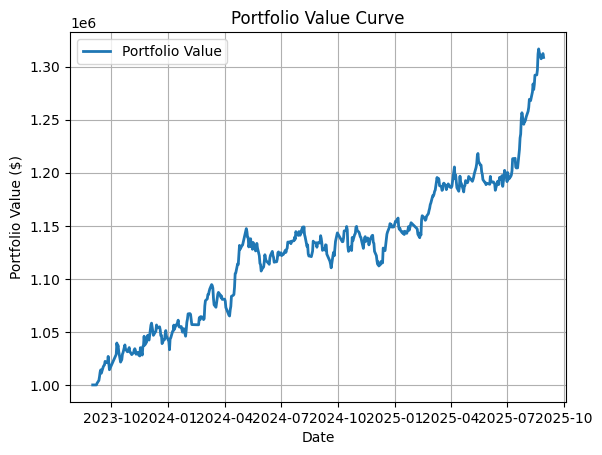

In [149]:
log_dates = strategy_instance.log_dates
log_values = strategy_instance.log_values
log_cash = strategy_instance.log_cash
equity_curve = pd.Series(log_values, index=pd.to_datetime(log_dates))
print(f'最低现金：{np.min(log_cash):,.2f}, 平均现金: {np.mean(log_cash):,.2f}')

plt.plot(figsize=(10, 10))
plt.plot(equity_curve.index, equity_curve.values, label='Portfolio Value', linewidth=2)
plt.title('Portfolio Value Curve')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

In [151]:
torch.save(model.state_dict(), 'params/panel_tf_rank.params')